In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import csv

from PIL import Image
from tensorflow import keras
from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical



image_size = 32

classes = [
          '[0]Ograničenje brzine [20]',
          '[1]Ograničenje brzine [30]',
          '[2]Ograničenje brzine [50]',
          '[3]Ograničenje brzine [60]',
          '[4]Ograničenje brzine [70]',
          '[5]Ograničenje brzine [80]',
          '[6]Ograničenje brzine [100]',
          '[7]Ograničenje brzine [120]'
          ]

In [ ]:

directory = "../german_data/SpeedTrain"

counter = 0
test_amount = 0
train_amount = 0
filename  = ""

with open('../german_data/Test.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        Cid = (int)(row['ClassId']) 
        
        if (Cid >= 0 and Cid < 6) or Cid == 7 or Cid == 8:
            #print(row['ClassId'],"\t", row['Path'])
            test_amount = test_amount + 1
            #print(Cid)


for root, subdirectories, files in os.walk(directory):
    for file in files:     
        filename = os.path.join(root, file)
        if filename.endswith('.ppm') or filename.endswith('.bmp') or filename.endswith('.png') or filename.endswith('.jpg'):   
            train_amount = train_amount + 1




print(test_amount,train_amount )

x_train = np.empty((train_amount , image_size, image_size, 3), dtype='uint8')
y_train = np.empty((train_amount  ,), dtype='uint8')

x_test = np.empty((test_amount  , image_size, image_size, 3), dtype='uint8')
y_test = np.empty((test_amount  ,), dtype='uint8')

In [ ]:


directory = "../german_data/SpeedTrain"

counter = 0

for root, subdirectories, files in os.walk(directory):
  for file in files:       
    filename = os.path.join(root, file)
    if filename.endswith('.ppm') or filename.endswith('.bmp') or filename.endswith('.png') or filename.endswith('.jpg'):   
            
      img = Image.open(filename)
      img = img.resize((image_size,image_size))
      data = np.asarray(img)   

      x_train[counter] = data
      y_train[counter] = (int)(root[-1:]) 

      counter += 1



In [ ]:
def collectTrainingData(num,filename):
    img = Image.open(filename)
    img = img.resize((image_size,image_size))
    data = np.asarray(img)   

    x_test[counters[num]] = data
    y_test[counters[num]] = num
    counters[num] = counters[num] + 1

counters = [0,0,0,0,0,0,0,0]

with open('../german_data/Test.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        Cid = (int)(row['ClassId']) 
        if Cid == 0:
            collectTrainingData(0,"../german_data/" + row['Path'])         
        elif Cid == 1:
            collectTrainingData(1,"../german_data/" + row['Path'])    
        elif Cid == 2:
            collectTrainingData(2,"../german_data/" + row['Path'])   
        elif Cid == 3:
            collectTrainingData(3,"../german_data/" + row['Path'])   
        elif Cid == 4:
            collectTrainingData(4,"../german_data/" + row['Path'])   
        elif Cid == 5:
            collectTrainingData(5,"../german_data/" + row['Path'])   
        elif Cid == 7:
            collectTrainingData(6,"../german_data/" + row['Path'])   
        elif Cid == 8:
            collectTrainingData(7,"../german_data/" + row['Path'])   

print(counters)


In [ ]:
np.save('../data_and_models/german_speed_signs_x_train', x_train)
np.save('../data_and_models/german_speed_signs_y_train', y_train)
np.save('../data_and_models/german_speed_signs_x_test', x_test)
np.save('../data_and_models/german_speed_signs_y_test', y_test)

In [ ]:
x_train = np.load('../data_and_models/german_speed_signs_x_train.npy')
y_train = np.load('../data_and_models/german_speed_signs_y_train.npy' )
x_test  = np.load('../data_and_models/german_speed_signs_x_test.npy' )
y_test  = np.load('../data_and_models/german_speed_signs_y_test.npy' )

In [ ]:
y_train_class = to_categorical(y_train)
y_test_class = to_categorical(y_test)
print(y_train_class[0])

In [ ]:

def equalize(image):
    image = cv2.equalizeHist(image)
    return image
def grayscale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def preprocessing(image):
    image = grayscale(image)
    image = equalize(image)
    image = image/255
    return image

x_train = np.array(list(map(preprocessing, x_train)))
x_test = np.array(list(map(preprocessing, x_test)))



In [ ]:
plt.imshow(x_train[random.randint(0, len(x_train) - 1)])
plt.axis('off')
print(x_train.shape)

In [ ]:
x_train = x_train.reshape(train_amount, 32, 32, 1)
x_test = x_test.reshape(test_amount, 32, 32, 1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

data_gen.fit(x_train)


In [ ]:
model = Sequential()
model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
model.add(Conv2D(60, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])  

hist = model.fit(x_train,y_train_class,
                 batch_size = 100,
                 epochs = 15,
                 validation_split = 0.12)

In [ ]:
model.save("../data_and_models/speed8german.h5")

In [ ]:
model = keras.models.load_model("../data_and_models/speed8german.h5")

In [ ]:
PATH = "C:/Users/matko/Desktop/test/555.jpg"
image = plt.imread(PATH) 
plt.imshow(image, cmap=plt.get_cmap('gray'))
print(image.shape)
image = np.asarray(image)
print(image.shape)
image = cv2.resize(image, (32, 32))
print(image.shape)
image = preprocessing(image)
print(image.shape)
image = image.reshape(1, 32, 32, 1)

print("predicted sign: "+ str(model.predict_classes(image)))

[[0 1 0 0 0 0 0 0]]
[1]Ograničenje brzine [30]


<Figure size 432x288 with 0 Axes>

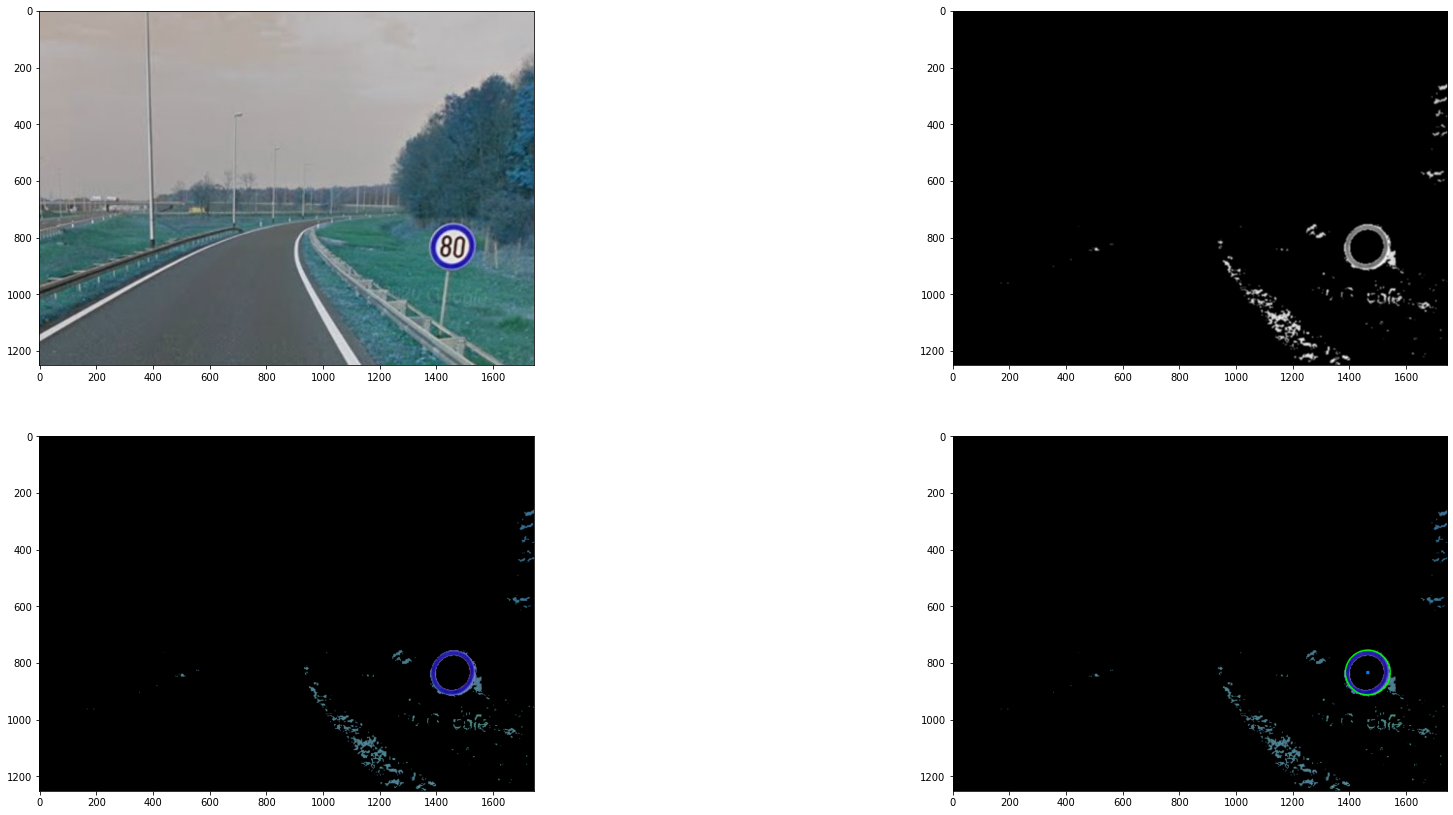

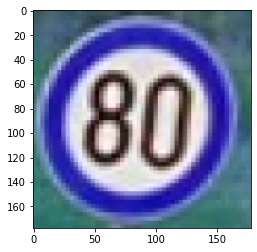

In [69]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.gray()
plt.figure(figsize=(30,30))

PATH = "C:/Users/matko/Desktop/3.jpg"
image = cv2.imread(PATH) 

# scale to about 1600px
scale_percent = int((3000 / (image.shape[0] + image.shape[1]) ) * 100) 
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


output = image.copy()

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

light_red = np.array([0,107,133])
dark_red = np.array([179,255,255])

#light_red = np.array([0,72,0])
#dark_red = np.array([179,255,97])

red_mask = cv2.inRange(hsv, light_red, dark_red)

red_output = cv2.bitwise_and(image,image, mask= red_mask)
red_output_copy = red_output.copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grayRed = cv2.cvtColor(red_output, cv2.COLOR_BGR2GRAY)

gray = cv2.GaussianBlur(gray,(7,7),cv2.BORDER_DEFAULT)
grayRed = cv2.GaussianBlur(grayRed,(7,7),cv2.BORDER_DEFAULT)

dp = 1.3
minDist = 100
minRadius = 25
maxRadius = 500

redCircles = cv2.HoughCircles(image=grayRed, method=cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,minRadius=minRadius,maxRadius=maxRadius)
#circles = cv2.HoughCircles(image=gray, method=cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,minRadius=minRadius,maxRadius=maxRadius)

#if circles is not None:
#	circles = np.round(circles[0, :]).astype("int")
#	for (x, y, r) in circles:		
#		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
#		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

croppedImages = []

if redCircles is not None:
	redCircles = np.round(redCircles[0, :]).astype("int")

	for (x, y, r) in redCircles:		
		cv2.circle(red_output_copy, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(red_output_copy, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
		rn = r + 10
		croppedImages.append(((image.copy()[y-rn:y+rn,x-rn:x+rn])))

plt.subplot(421), plt.imshow(image)
#plt.subplot(422), plt.imshow(output)
plt.subplot(422), plt.imshow(grayRed)
plt.subplot(423), plt.imshow(red_output)
plt.subplot(424), plt.imshow(red_output_copy)


for mod_image in croppedImages:

	plt.figure()

	plt.imshow(mod_image)
	mod_image = np.asarray(mod_image)
	mod_image = cv2.resize(mod_image, (32, 32))
	mod_image = preprocessing(mod_image)
	mod_image = mod_image.reshape(1, 32, 32, 1)

	predict = (model.predict(mod_image) > 0.5).astype("int32")

	counter = 0
	for x in predict[0]:		
		if x == 1:
			break
		counter += 1
	print(predict)
	if counter != 8:
		print(classes[counter])


